# LWA1 Source Maps

### Maps/data needed for each frequency for Commander runs:
1. Files (.fits):
    1. Intensity map .fits file
    2. Noise map .fits file
    3. Mask .fits file
    4. Beam .fits file
2. Monopole/dipole values for each freq band map
3. Defaults file for each freq band:
    1. BAND_LABEL&&&  
    2. Nside
    3. Lmax
    4. Band mapfile path
    5. Band noisefile path
    6. Band maskfile path
    7. Band beamfile path
    8. Band nominal frequency
 
#### LWA1 maps details
Sky maps released by the LWA1 group are in HEALPix sky pixelization for equatorial coordinates with an approximate pixel size of 0.23 degrees and in equatorial Mollweide projection with an approximate pixel size of 0.3 degrees.

### Misc.
Filenames:
1. ???

NOTE:
1. lwa1 fits files are in equatorial coordinates.

Need:
1. param file
2. default file defining details about map
3. job submission file

Telescope details:
1. declination, 
2. resolution, 
3. scan strategy, 
4. mapmaking

### Meetings/Advice/Etc.:

1. Sources of uncertainties/errors: (Lukas email)
    - temperature scale error
    - Confusion limit ---> do not include in rms map
2. 10-NOV-22 Meeting 
    - FOR LWA1 noise:
        - look at output chi2 from comm --> reduced chi2 should be close to 1 (not 0.001 or 1000)
        - data - signal model / standard deviation


### Commander Runs
- LATEST LWA1 run:
    - num chains              = 1
    - num gibbs iterations    = 200
    - sample amplitude        = true
    - sample spectral indices = true
    - gain sampling           = false
    - bands                   =   (1) haslam 
                                (2) 80lwa1
    - comps                   =   (1) synch 
                                (2) md 
                                (3) ff

In [24]:
import glob
from cmath import nan

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.titlesize'] = 12
# mpl.rcParams['axes.titlesize'] = 12
# mpl.rcParams['font.size'] = 8
# mpl.rcParams['figure.dpi'] = 300

from datetime import datetime
now = datetime.now()
# plt.rcParams['savefig.facecolor']='white'

from pathlib import Path
visualization_path = Path("../visualization/")
figs_path = Path(visualization_path/"figs/")
LWA1_map_images_path = Path(visualization_path/"map-images/LWA1_source/")
data_path = Path("../data/")
LWA1_source_path = Path(data_path/"LWA1_source/")
commander_in_path = Path(data_path/"commander_in/")

figs_path.mkdir(parents=True, exist_ok=True)
LWA1_map_images_path.mkdir(parents=True, exist_ok=True)
LWA1_source_path.mkdir(parents=True, exist_ok=True)
commander_in_path.mkdir(parents=True, exist_ok=True)

import h5py as h5
import lwa1_module as lwa1
import visualization as vis

## Create LWA1 maps for Commander input

In [25]:
def change_coord(m, coord):
    """Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

### Functions to create & save fits files for the maps & masks

Note: The noise mask is bigger than the intensity map mask (i.e. the intensity mask is a SUBSET of the noise mask), so probably better to create the mask map using the noise map.

In [26]:
freqs_lwa1 = [35, 38, 40, 45, 50, 60, 70, 74, 80]

def create_dict_fits(freqs=freqs_lwa1):
    """Create a dictionary of fits files for the LWA1 maps.

    Parameters
    ----------
    freqs : list
        List of frequencies to create maps for.
        
    Returns
    -------
    dict_maps : dict
        Dictionary of intensity maps for each frequency.
    dict_errs : dict
        Dictionary of error/noise maps for each frequency.
        
    Notes
    -----
    The maps are saved as fits files in the 'commander_inputs' directory.
    The maps are also returned as a dictionary.
    The maps are in galactic/equatorial coordinates.
    The maps are masked for bad pixels.

    """
    dict_maps = {}
    dict_errs = {}
    for f in freqs:
        freq = f"{f}"
        print(f"Creating maps for {freq}mhz...")
        # Import healpix maps in equatorial coords
        file_map = f"healpix-all-sky-rav-wsclean-map-{f}.fits"
        file_err = f"healpix-all-sky-rav-wsclean-err-{f}.fits"
        map_equat = hp.fitsfunc.read_map(LWA1_source_path/file_map, dtype=None)
        err_equat = hp.fitsfunc.read_map(LWA1_source_path/file_err, dtype=None)

        #
        # Change coordinates from equatorial to galactic/celestial
        #
        map_celest = change_coord(map_equat, ['C', 'G'])
        err_celest = change_coord(err_equat, ['C', 'G'])

        # print(f"{f}mhz -- Map size: ", maps_lwa1[f"{f}mhz"].size)
    
        # Mask the bad pixels
        dict_maps[freq] = mask_badsig(map_celest)
        dict_errs[freq] = mask_badsig(err_celest)

    # Create and save mask-maps for both the intensity and error/noise maps
    dict_maps, dict_errs, _, _ = create_masks(dict_maps, dict_errs)

    # #
    # # Save the maps as fits files with the right names etc.
    # #
    # map_fits_file = Path(f"LWA1-00{freq}/LWA1-00{freq}_map.fits")
    # map_fits_file.mkdir(parents=True, exist_ok=True)
    # err_fits_file = Path(f"LWA1-00{freq}/LWA1-00{freq}_err.fits")
    # err_fits_file.mkdir(parents=True, exist_ok=True)
    # hp.fitsfunc.write_map(commander_in_path/map_fits_file, maps[freq], overwrite=True, dtype=None)
    # hp.fitsfunc.write_map(commander_in_path/err_fits_file, errs[freq], overwrite=True, dtype=None)
    
    return dict_maps, dict_errs

def mask_badsig(map):
    """Mask bad pixels in the LWA1 maps.

    Parameters
    ----------
    map : array
        Map to be masked.

    Returns
    -------
    map : array
        Masked map.

    Notes
    -----
    The bad pixels are set to 'nan' values.
    Doing these checks for bad pixels, aka pixel values <= 0. 

    """
    # print(f"\n{freq} -- BEFORE NAN-ing bad-pixels:")
    #
    # Find the nan-valued pixels
    #
    idx_mask = np.argwhere(np.isnan(map))
    # print(f"{freq} -- No. of nan pixels (to be masked): ", idx_mask.size)
    # print("indices for nan pixels (to be masked):\n", idx_mask)

    #
    # Find the <=0 pixels:
    #
    idx_badpix = np.where(map <= 0) 
    #
    # The above is a tuple with at least 1 element, i.e. an empty array.
    # So to check the size of the array contained by the tuple, I need to extract the array (as below)
    #
    idx_badpix = idx_badpix[0]
    # print(f"(1) No. of pixels <= 0: ", idx_badpix.size)
    # print(f"(2) No. of pixels <= 0: ", (map <= 0).sum()) # This is another way to check for pixels valued <=0
    # print("indices of pixels <= 0:\n", idx_badpix)

    #
    # if there are pixels <=0 (there are quite a few for the noise maps, for some reason), we set them to 'nan' as: 
    #
    # print(map[idx_badpix])
    map[idx_badpix] = nan 

    #
    # Now check again to see if there are any bad pixels left...
    #
    idx_badpix = np.where(map <= 1)[0]
    # print("AFTER NAN-ing bad pixels:")
    # print("(1) No. of pixels <= 0:", idx_badpix.size)
    # print("(2) No. of pixels <= 0:", (map <= 0).sum()) # This is another way to check for pixels valued <=0
    # print("indices of pixels <= 0:\n", idx_badpix)

    # 
    # Now we update our array of indices for nan-pixels
    # 
    idx_mask = np.argwhere(np.isnan(map))
    # print("AFTER: No. of nan pixels (to be masked):", idx_mask.size)

    # print(map[idx_mask])
    
    return map

def create_masks(maps, errs):
    """Create masks for the maps and errors.
    
    Args:
        maps (dict): Dictionary of maps
        errs (dict): Dictionary of errors

    Returns:
        maps (dict): Dictionary of maps with masks
        errs (dict): Dictionary of errors with masks
        mask_maps (dict): Dictionary of masks for the maps
        mask_errs (dict): Dictionary of masks for the errors

    Notes:
        The masks are created by checking if the pixel values in the maps and errors are the same.
        If they are not, then the pixel is masked.
        The masks are saved as fits files.

    TODO:
        - Check if the masks are the same for the maps and errors

    """
    for freq,map,err in zip(maps.keys(), maps.values(), errs.values()):
        # This for loop will iterate through the maps and errors, and create masks for each map and error.
        print(f"\nCreating mask-maps for {freq}mhz...")
        
        # Find the nan-valued pixels in the maps
        idx_mask_map = np.argwhere(np.isnan(map))
        idx_mask_err = np.argwhere(np.isnan(err))

        # print("Intensity vs. noise mask-map sizes: ", idx_mask_map.size, idx_mask_err.size)

        # Check if there are any mask-pix in the intensity map that are not in the noise map
        mapdifferr = np.setdiff1d(idx_mask_map, idx_mask_err)
        
        # print("Mask-pix in intensity NOT in noise: ", mapdifferr.size)

        # Check if there are any mask-pix in the noise map that are not in the intensity map
        errdiffmap = np.setdiff1d(idx_mask_err, idx_mask_map)
        
        # print("Mask-pix in noise NOT in intensity: ", errdiffmap.size)

        idx_mask_combined = np.union1d(idx_mask_map, idx_mask_err)
        
        # print("Size of combined pix-mask-map: ", idx_mask_combined.size)
        
        map[idx_mask_combined] = nan
        err[idx_mask_combined] = nan
        maps[freq] = map
        errs[freq] = err

        #
        # Save the maps as fits files with the right names etc.
        #
        map_fits_dir = Path(commander_in_path/f"LWA1-00{freq}/")
        err_fits_dir = Path(commander_in_path/f"LWA1-00{freq}/")
        map_fits_dir.mkdir(parents=True, exist_ok=True)
        err_fits_dir.mkdir(parents=True, exist_ok=True)
        map_fits_file = f"LWA1-00{freq}_map.fits"
        err_fits_file = f"LWA1-00{freq}_err.fits"
        hp.fitsfunc.write_map(map_fits_dir/map_fits_file, maps[freq], overwrite=True, dtype=None)
        hp.fitsfunc.write_map(err_fits_dir/err_fits_file, errs[freq], overwrite=True, dtype=None)

        # if errdiffmap.size > mapdifferr.size:
        #     #
        #     # The mask we'll use is the noise map mask:
        #     #
        #     maps[freq][errdiffmap] = nan
        #     idx_mask = idx_mask_err
        #     #
        #     # Save the map as a fits file with the right name etc.
        #     #
        #     map_fits_file = f"LWA1-00{freq}/LWA1-00{freq}_map.fits"
        #     map_fits_file.mkdir(parents=True, exist_ok=True)
        #     hp.fitsfunc.write_map(commander_in_path/map_fits_file, maps[freq], overwrite=True, dtype=None)
        # else:
        #     #
        #     # The mask we'll use is the intensity map mask:
        #     #
        #     errs[freq][mapdifferr] = nan
        #     idx_mask = idx_mask_map
        #     #
        #     # Save the map as a fits file with the right name etc.
        #     #
        #     err_fits_file = f"LWA1-00{freq}/LWA1-00{freq}_err.fits"
        #     err_fits_file.mkdir(parents=True, exist_ok=True)
        #     hp.fitsfunc.write_map(commander_in_path/err_fits_file, errs[freq], overwrite=True, dtype=None)

        goodmask_map = hp.mask_good(map)
        goodmask_err = hp.mask_good(err)
        idx_mask_map = np.where(goodmask_err==False)[0]
        idx_mask_err = np.where(goodmask_map==False)[0]
        
        # print("Intensity vs. noise mask-map sizes: ", idx_mask_map.size, idx_mask_err.size)

        mask_map = goodmask_map.astype(int)
        mask_err = goodmask_err.astype(int)

        mask_fits_dir = Path(commander_in_path/f"LWA1-00{freq}/")
        mask_fits_dir.mkdir(parents=True, exist_ok=True)
        mask_fits_file = f"LWA1-00{freq}_maskmap.fits"
        hp.fitsfunc.write_map(mask_fits_dir/mask_fits_file, mask_map, overwrite=True, dtype=None)

    return maps, errs, mask_map, mask_err


vals_kK = [[0,40], [0,30], [0,25], [0,20], [0,15], [0,10], [0,7], [0,6], [0,5]]
def init_dict_cbrange(dict_fits, vals_kK=vals_kK):
    """Initialize the dictionaries of colorbar ranges for the LWA1 maps.

    Args:
        dict_fits (dict): Dictionary of fits files for the LWA1 maps.
        vals_kK (list): List of lists of colorbar ranges for the LWA1 maps.

    Returns:
        cbrange_K (dict): Dictionary of colorbar ranges for the LWA1 maps in K.
        cbrange_kK (dict): Dictionary of colorbar ranges for the LWA1 maps in kK.

    Notes:
        The colorbar ranges are in Kelvin (K) and kilo-Kelvin (kK).

    """
    ### Create dictionaries of temperature ranges for healpy colorbars for each freq map ###
    # cb_ranges = dict.fromkeys(maps_lwa1.keys())
    # temp_ranges = {x:maps_lwa1[freq] for freq in maps_lwa1.keys()}
    vals_kK = [[float(y) for y in x] for x in vals_kK]
    vals_K = [[y*1000.0 for y in x] for x in vals_kK]

    cbrange_kK=dict(zip(dict_fits.keys(), vals_kK))
    cbrange_K=dict(zip(dict_fits.keys(), vals_K))

    # print(cbrange_K)
    
    return cbrange_K, cbrange_kK


def pct_errs(maps, errs):
    """Calculate the percentage errors in the maps.

    Args:
        maps (dict): Dictionary of maps
        errs (dict): Dictionary of errors

    Returns:
        pct_errs (dict): Dictionary of percentage errors

    Notes:
        The percentage errors are calculated as the errors divided by the maps, multiplied by 100.

    """
    pct_errs = dict.fromkeys(maps.keys())
    for freq,map,err in zip(maps.keys(), maps.values(), errs.values()):
        pct_errs[freq] = err/map * 100.0

    return pct_errs
        


### Functions for beam files & mds

35 MHz - Stokes I - 4.7° beam

38 MHz - Stokes I - 4.3° beam

40 MHz - Stokes I - 4.1° beam

45 MHz - Stokes I - 3.6° beam

50 MHz - Stokes I - 3.3° beam

60 MHz - Stokes I - 2.7° beam

70 MHz - Stokes I - 2.3° beam

74 MHz - Stokes I - 2.2° beam

80 MHz - Stokes I - 2.0° beam

In [27]:
#
# To find FWHM, we're given the beam size/FWHM in degrees, so just convert to radians (beamsize*pi/180)
# To calculate l_{max}: nside*3 - 1 
#   (but add a small value to the l_max to avoid aliasing??)
# Compute b_{lm} using healpy.spherfunc.gauss_beam with FWHM and l_{max} as input and beam window function [0, l_{max}].
# Use Healpy to write the calculated C(l) to a fits file for each frequency.
#
# Beam sizes:
# 35 MHz - Stokes I - 4.7° beam
# 38 MHz - Stokes I - 4.3° beam
# 40 MHz - Stokes I - 4.1° beam
# 45 MHz - Stokes I - 3.6° beam
# 50 MHz - Stokes I - 3.3° beam
# 60 MHz - Stokes I - 2.7° beam
# 70 MHz - Stokes I - 2.3° beam
# 74 MHz - Stokes I - 2.2° beam
# 80 MHz - Stokes I - 2.0° beam
#

# Create a dictionary of beam sizes for each frequency (using the data in the above comment, with the frequencies as string type keys and the beam sizes as values):
beam_sizes = {'35': 4.7, '38': 4.3, '40': 4.1, '45': 3.6, '50': 3.3, '60': 2.7, '70': 2.3, '74': 2.2, '80': 2.0}

# Create a function to calculate the beam window function for each frequency (without using a for loop, if possible), write the beam window function to a fits file, and return the beamcls as a dictionary (with the frequencies as keys and the beam window functions as values) and the lmax as a separate dictionary (with the frequencies as keys and the lmax as values):
def calc_beam_window_funcs(beam_sizes):
    """Calculate the beam window function for each frequency and write the beam window function to a fits file.
    
    Args:
        beam_sizes (dict): Dictionary of beam sizes for each frequency.
        
    Returns:
        beamcls (dict): Dictionary of beam window functions for each frequency.
        lmax (dict): Dictionary of lmax for each frequency.

    Notes:
        The beam window function is calculated using the Healpy function hp.spherfunc.gauss_beam() and written to a fits file using the Healpy function hp.fitsfunc.write_cl().
        The beam window function is returned as a dictionary with the frequencies as keys and the beam window functions as values.
        The lmax is returned as a separate dictionary with the frequencies as keys and the lmax as values.

    """
    beamcls = {}
    lmax_dict = {}
    for freq,beamsize in beam_sizes.items():
        fwhm = beamsize*np.pi/180
        nside = 256
        lmax = (nside * 3 - 1) + 10 # Add a small value to the l_max to avoid aliasing?? Or is there another reason?

        beamcls[freq] = hp.sphtfunc.gauss_beam(fwhm=fwhm, lmax=lmax)
        lmax_dict[freq] = lmax

        beam_fits_dir = Path(commander_in_path/f"LWA1-00{freq}/")
        beam_fits_dir.mkdir(parents=True, exist_ok=True)
        beam_fits_file = f"LWA1-00{freq}_beam.fits"
        hp.fitsfunc.write_cl(filename=beam_fits_dir/beam_fits_file, cl=beamcls[freq], overwrite=True, dtype=None)
    
    return beamcls, lmax_dict


# Create a function to calculate the monopole (mp) and dipole (dp) using the maps_lwa1 dictionary at every frequency. Use the Healpy function hp.fit_dipole() to calculate the monopole and dipole values (collectively abbreviated as md). The function should return the md values as a dictionary with the frequencies as keys and the md values as values. Also, print the results, with Monopole and Dipole given separately.
def calc_md(maps):
    """Calculate the monopole and dipole for each frequency.
    
    Args:
        maps_lwa1 (dict): Dictionary of maps for each frequency.
        
    Returns:
        md (dict): Dictionary of monopole and dipole values for each frequency.

    Notes:
        The monopole and dipole values are calculated using the Healpy function hp.fit_dipole() and returned as a dictionary with the frequencies as keys and the monopole and dipole values as values.
        The monopole and dipole values are printed separately.

    """
    md = {}
    for freq,map in maps.items():
        md[freq] = hp.fit_dipole(map)
        print(f"{freq} MHz Monopole: {md[freq][0]}")
        print(f"{freq} MHz Dipole: {md[freq][1]}")
    
    return md



In [28]:
maps_lwa1, errs_lwa1 = create_dict_fits()
pct_errs_lwa1 = pct_errs(maps_lwa1, errs_lwa1)
cbrange_K, cbrange_kK = init_dict_cbrange(maps_lwa1)

Creating maps for 35mhz...


/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Creating maps for 38mhz...
Creating maps for 40mhz...
Creating maps for 45mhz...
Creating maps for 50mhz...
Creating maps for 60mhz...
Creating maps for 70mhz...
Creating maps for 74mhz...
Creating maps for 80mhz...

Creating mask-maps for 35mhz...


/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(



Creating mask-maps for 38mhz...

Creating mask-maps for 40mhz...

Creating mask-maps for 45mhz...

Creating mask-maps for 50mhz...

Creating mask-maps for 60mhz...

Creating mask-maps for 70mhz...

Creating mask-maps for 74mhz...

Creating mask-maps for 80mhz...


/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/fitsfunc.py:99: FutureWarning: The default dtype of write_cl() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


{'35': 777, '38': 777, '40': 777, '45': 777, '50': 777, '60': 777, '70': 777, '74': 777, '80': 777}


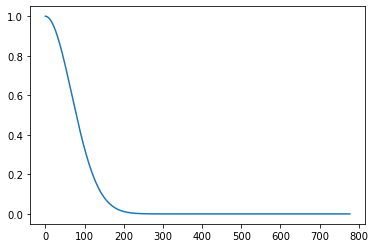

In [29]:
beamcls, lmax_dict = calc_beam_window_funcs(beam_sizes)
# print lmax_dict
print(lmax_dict)
# Plot the beam window function for 80 MHz:
x = range(beamcls['80'].size)
plt.plot(x, beamcls['80'])

In [30]:
md = calc_md(maps_lwa1)

35 MHz Monopole: 16515.298895022355
35 MHz Dipole: [6583.97833065 2828.38670852 -427.16020277]
38 MHz Monopole: 12895.606870858159
38 MHz Dipole: [5483.37170266 3355.33368788  376.39784768]
40 MHz Monopole: 10925.346903627531
40 MHz Dipole: [4656.06266551 3109.03862315  449.04787475]
45 MHz Monopole: 8156.389604181464
45 MHz Dipole: [3565.71149374 2600.45398873  380.14358763]
50 MHz Monopole: 6575.227939058878
50 MHz Dipole: [2907.59934505 1774.28496442  191.21401332]
60 MHz Monopole: 4437.98339693108
60 MHz Dipole: [1880.50088099 1087.73340983  -48.45909153]
70 MHz Monopole: 2907.99197084221
70 MHz Dipole: [1116.58261409  896.26976182   30.56736769]
74 MHz Monopole: 2647.702807289436
74 MHz Dipole: [1027.34672363  686.64164757   17.9316443 ]
80 MHz Monopole: 2214.003599620877
80 MHz Dipole: [893.18359529 507.1652158  -16.81614988]


### Testing out some monopole/dipole stuff using galcuts:

/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


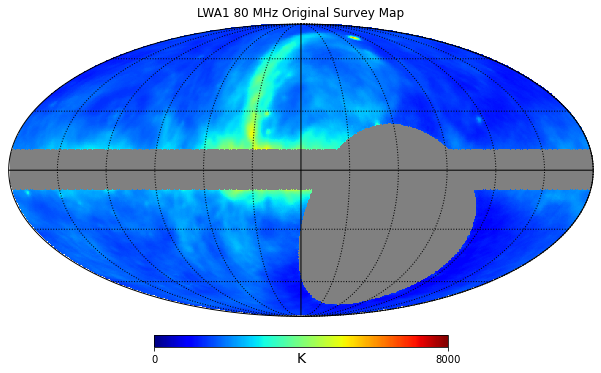

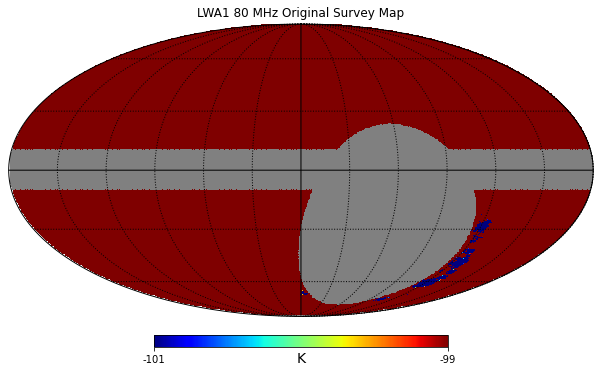

In [31]:
import copy

# min = 0.0
# max = 8000.0
min = 100.0
max = -100.0
gcut = 10.0

###############################
thetadiff = np.radians(gcut)
theta1 = np.pi/2 - thetadiff
theta2 = np.pi/2 + thetadiff
ipix_strip = hp.query_strip(nside=256, theta1=theta1, theta2=theta2, inclusive=True)
test_dict = copy.deepcopy(maps_lwa1)
test_dict['80'][ipix_strip] = nan

hp.mollview(test_dict['80'], title="LWA1 80 MHz Original Survey Map", min=0.0, max=8000.0, cmap='jet', unit='K')
hp.graticule()
###############################

hp.mollview(test_dict['80']-1120, title="LWA1 80 MHz Original Survey Map", min=min, max=max, cmap='jet', unit='K')
hp.graticule()

Monopole from Dowell & Taylor, 2018

In [32]:
# Extract monopole/dipole from the map
# gcut = 0.0
# gcut = 15.0
# gcut = 30.0
# map_80 = copy.deepcopy(maps_lwa1['80'])
# md_80mlwa1 = hp.fit_dipole(map_80,  gal_cut=gcut)
# mp_80mlwa1 = hp.fit_monopole(map_80, gal_cut=gcut)

# print(md_80mlwa1)
# print(mp_80mlwa1)

# Write a function to perform gal_cut on maps for all nine LWA1 frequency bands (with the map data input as a dictionary), apply the gal_cut, find the monopole and dipole using hp.fit_dipole, and return the monopole and dipole values as a dictionary with the frequencies as keys and the monopole and dipole values as values. Also, print the results, with Monopole and Dipole given separately.
def gal_cut_md(maps, gcut):
    """Perform gal_cut on maps for all nine LWA1 frequency bands and calculate the monopole and dipole for each frequency.
    
    Args:
        maps (dict): Dictionary of maps for each frequency.
        gcut (float): The gal_cut value to use.
        
    Returns:
        md (dict): Dictionary of monopole and dipole values for each frequency.

    Notes:
        The monopole and dipole values are calculated using the Healpy function hp.fit_dipole() and returned as a dictionary with the frequencies as keys and the monopole and dipole values as values.
        The monopole and dipole values are printed separately.

    """
    md = {} # Initialize the dictionary to hold the monopole and dipole values.
    for freq,map in maps.items():
        map_gcut = copy.deepcopy(map) # Create a copy of the map to apply the gal_cut to.
        thetadiff = np.radians(gcut) # Convert the gal_cut value to radians.
        theta1 = np.pi/2 - thetadiff 
        theta2 = np.pi/2 + thetadiff
        ipix_strip = hp.query_strip(nside=256, theta1=theta1, theta2=theta2, inclusive=True) # Find the pixels in the strip.
        map_gcut[ipix_strip] = nan # Set the pixels in the strip to nan.
        md[freq] = hp.fit_dipole(map_gcut) # Calculate the monopole and dipole for the map with the gal_cut applied.
        print(f"{freq} MHz Monopole: {md[freq][0]}")
        print(f"{freq} MHz Dipole: {md[freq][1]}")

    return md

# Calculate the monopole and dipole for each frequency using the gal_cut_md() function.
gcut = 0.0
gcut = 30.0
gcut = 15.0
md_gcut = gal_cut_md(maps_lwa1, gcut)


35 MHz Monopole: 13663.81652582225
35 MHz Dipole: [3595.10711136 1246.8015368   192.11332033]
38 MHz Monopole: 10377.020025928103
38 MHz Dipole: [2984.56372597 2334.01649295  976.26943132]
40 MHz Monopole: 8719.571358675888
40 MHz Dipole: [2502.69500636 2236.44442927  978.44624246]
45 MHz Monopole: 6367.375250299536
45 MHz Dipole: [1843.76431443 1812.08366822  802.96187464]
50 MHz Monopole: 5162.644565269943
50 MHz Dipole: [1546.17495977 1097.13965278  519.33650862]
60 MHz Monopole: 3522.0372270455164
60 MHz Dipole: [990.26051468 682.8734676  169.40451936]
70 MHz Monopole: 2307.3834402702564
70 MHz Dipole: [502.14330809 628.41054492 175.9108885 ]
74 MHz Monopole: 2105.81583129561
74 MHz Dipole: [496.87096797 430.14102834 146.32401858]
80 MHz Monopole: 1761.3843497903576
80 MHz Dipole: [445.42877123 300.67637103  92.94919358]


In [33]:
# band              monopole      dipole_x      dipole_y      dipole_z      prior_mean_mp prior_mean_x  prior_mean_y  prior_mean_z  std_mp        std_dp
#   0.035-LWA1       0.165E+05     0.658E+04     0.283E+04    -0.427E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.038-LWA1       0.129E+05     0.548E+04     0.336E+04     0.376E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.040-LWA1       0.109E+05     0.466E+04     0.311E+04     0.449E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.045-LWA1       0.816E+04     0.357E+04     0.260E+04     0.380E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.050-LWA1       0.658E+04     0.291E+04     0.177E+04     0.191E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.060-LWA1       0.444E+04     0.188E+04     0.109E+04    -0.485E+02     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.070-LWA1       0.291E+04     0.112E+04     0.896E+03     0.306E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.074-LWA1       0.265E+04     0.103E+04     0.687E+03     0.179E+03     0.000E+00     0.000E+00     0.000E+00     0.000E+00     0.100E-02     0.100E-05
#   0.080-LWA1       0.221E+04     0.893E+03     0.507E+03    -0.168E+02     0.180E+04     0.500E+03     0.300E+03    -0.010E+02     0.100E+03     0.100E+00

# # Rewrite the data above using md values, as demonstrated in the last line above for 0.080-LWA1 (corresponding to 80 MHz), from the md_gcut dictionary provided below, filling in the columns: prior_mean_mp, prior_mean_x, prior_mean_y, prior_mean_z with the monopole and dipole values from md_gcut. Do not modify the monopole, dipole_x, dipole_y, dipole_z, std_mp, or std_dp columns.
# # The md values from md_gcut are:
# # 35 MHz Monopole: 13663.81652582225
# # 35 MHz Dipole: [3595.10711136 1246.8015368   192.11332033]
# # 38 MHz Monopole: 10377.020025928103
# # 38 MHz Dipole: [2984.56372597 2334.01649295  976.26943132]
# # 40 MHz Monopole: 8719.571358675888
# # 40 MHz Dipole: [2502.69500636 2236.44442927  978.44624246]
# # 45 MHz Monopole: 6367.375250299536
# # 45 MHz Dipole: [1843.76431443 1812.08366822  802.96187464]
# # 50 MHz Monopole: 5162.644565269943
# # 50 MHz Dipole: [1546.17495977 1097.13965278  519.33650862]
# # 60 MHz Monopole: 3522.0372270455164
# # 60 MHz Dipole: [990.26051468 682.8734676  169.40451936]
# # 70 MHz Monopole: 2307.3834402702564
# # 70 MHz Dipole: [502.14330809 628.41054492 175.9108885 ]
# # 74 MHz Monopole: 2105.81583129561
# # 74 MHz Dipole: [496.87096797 430.14102834 146.32401858]
# # 80 MHz Monopole: 1761.3843497903576
# # 80 MHz Dipole: [445.42877123 300.67637103  92.94919358]

# # Round up the values to the third significant place. Use scientific notation accurately, e.g. the prior_mean_mp monopole value for 35 MHz should be 0.137E+05, not 0.137E+04. Do not modify the monopole, dipole_x, dipole_y, dipole_z, std_mp, or std_dp columns in the table above. Instead, fill in the prior_mean_mp, prior_mean_x, prior_mean_y, prior_mean_z columns with the monopole and dipole values from md_gcut.
#   0.035-LWA1       0.165E+05     0.658E+04     0.283E+04    -0.427E+03     0.137E+05     0.360E+04     0.125E+04     0.192E+03     0.500E+04     0.500E+02
#   0.038-LWA1       0.129E+05     0.548E+04     0.336E+04     0.376E+03     0.104E+05     0.299E+04     0.233E+04     0.976E+03     0.500E+04     0.500E+02
#   0.040-LWA1       0.109E+05     0.466E+04     0.311E+04     0.449E+03     0.872E+04     0.250E+04     0.224E+04     0.978E+03     0.500E+04     0.500E+02
#   0.045-LWA1       0.816E+04     0.357E+04     0.260E+04     0.380E+03     0.637E+04     0.184E+04     0.181E+04     0.803E+03     0.500E+03     0.500E+02
#   0.050-LWA1       0.658E+04     0.291E+04     0.177E+04     0.191E+03     0.516E+04     0.155E+04     0.110E+04     0.519E+03     0.500E+03     0.500E+02
#   0.060-LWA1       0.444E+04     0.188E+04     0.109E+04    -0.485E+02     0.352E+04     0.990E+03     0.683E+03     0.169E+03     0.500E+03     0.500E+02
#   0.070-LWA1       0.291E+04     0.112E+04     0.896E+03     0.306E+03     0.231E+04     0.502E+03     0.628E+03     0.176E+03     0.500E+03     0.500E+02
#   0.074-LWA1       0.265E+04     0.103E+04     0.687E+03     0.179E+03     0.211E+04     0.497E+03     0.430E+03     0.146E+03     0.500E+03     0.500E+02
#   0.080-LWA1       0.221E+04     0.893E+03     0.507E+03    -0.168E+02     0.180E+04     0.445E+03     0.301E+03     0.930E+02     0.500E+03     0.500E+01


In [34]:
# Frequency
# (MHz)	Centre frequency
# (MHz)	Bandwidth
# (kHz)	Beam size
# (degrees)	Confusion
# noiseb (Jy beam−1)	Thermal
# noisec (Jy beam−1)
# 35	34.979	957	4.8 × 4.5	163	38
# 38	38.042	957	4.5 × 4.1	130	31
# 40	40.052	957	4.3 × 3.9	114	27
# 45	44.933	957	3.8 × 3.5	82	20
# 50	50.005	957	3.4 × 3.1	62	16
# 60	59.985	957	2.8 × 2.6	38	10
# 70	70.007	957	2.4 × 2.2	25	7
# 74	73.931	957	2.3 × 2.1	22	6
# 80	79.960	957	2.1 × 2.0	18	5


Defaults file for each freq band:
1. BAND_LABEL&&&  
2. BAND_MAPFILE&&& 
3. BAND_NOISEFILE&&& 
4. BAND_MASKFILE&&&
5. BAND_BEAM_B_L_FILE&&&
6. BAND_NOMINAL_FREQ&&&

In [35]:
# Using the .defaults file for LWA1 80 MHz freq band (/mn/stornext/d16/cmbco/AST9240/2022/jibran/commander_inputs/defaults/LWA1-0080.defaults), create .defaults files for all the other eight LWA1 freq bands (35, 38, 40, 45, 50, 60, 70, 74 MHz) and save them with respective filenames in the same directory as the LWA1-0080.defaults file. 
# Modify the .defaults file for each freq band by changing the following parameters:
# BAND_LABEL&&& (e.g. "BAND_LABEL&&& = LWA1-0080" to "BAND_LABEL&&& = LWA1-0035")
# BAND_MAPFILE&&& (e.g. "BAND_MAPFILE&&& = jibran/LWA1_data/LWA1-0080/LWA1-0080_map.fits" to "BAND_MAPFILE&&& = jibran/LWA1_data/LWA1-0035/LWA1-0035_map.fits)
# BAND_NOISEFILE&&& (e.g. "BAND_NOISEFILE&&& = jibran/LWA1_data/LWA1-0080/LWA1-0080_err.fits" to "BAND_NOISEFILE&&& = jibran/LWA1_data/LWA1-0035/LWA1-0035_err.fits")
# BAND_MASKFILE&&& (e.g. "BAND_MASKFILE&&& = jibran/LWA1_data/LWA1-0080/LWA1-0080_maskmap.fits" to "BAND_MASKFILE&&& = jibran/LWA1_data/LWA1-0035/LWA1-0035_maskmap.fits")
# BAND_BEAM_B_L_FILE&&& (e.g. "BAND_BEAM_B_L_FILE&&& = jibran/LWA1_data/LWA1-0080/LWA1-0080_beam.fits" to "BAND_BEAM_B_L_FILE&&& = jibran/LWA1_data/LWA1-0035/LWA1-0035_beam.fits")
# BAND_NOMINAL_FREQ&&& (e.g. "BAND_NOMINAL_FREQ&&& = 0.079960" to "BAND_NOMINAL_FREQ&&& = 0.034979" using freq values stored in the lwa1_centre_freqs dictionary with frequencies in MHz as keys and centre frequencies in GHz as values, e.g. '80': 0.079960 to '35': 0.034979)
# Import the LWA1-0080.defaults file in the line below and start writing the code to modify and save the .defaults files for the other eight LWA1 freq bands (make sure to write comments explaining what each line of code does):
import os
import re

# Create a dictionary using the LWA1 survey parameters above with the frequency as the string type key and the centre frequency as the value, e.g. '35': 34.979
lwa1_centre_freqs = {'35': 34.979, '38': 38.042, '40': 40.052, '45': 44.933, '50': 50.005, '60': 59.985, '70': 70.007, '74': 73.931, '80': 79.960}
lwa1_defaults_dir = '/mn/stornext/d16/cmbco/AST9240/2022/jibran/commander_inputs/defaults/'
lwa1_0080_defaults_filename = 'LWA1-0080.defaults'
lwa1_0080_defaults_file = os.path.join(lwa1_defaults_dir, lwa1_0080_defaults_filename) # join the path to the LWA1-0080.defaults file with the filename to get the full path to the LWA1-0080.defaults file



lwa1_defaults_files = lwa1.create_lwa1_defaults_files(lwa1_centre_freqs, lwa1_0080_defaults_file, 80)



Frequency band: 35 MHz
Deleted existing .defaults file for LWA1-0035 MHz...
Creating new .defaults file for LWA1-0035 MHz...
Writing modified lines to the new .defaults file...
First line found...
Line: #LWA1 80 MHz All-Sky Map default parameters

New line:  #LWA1 35 MHz All-Sky Map default parameters

Modified line:  #LWA1 35 MHz All-Sky Map default parameters

First line found...
Line: #LWA1 80 MHz All-Sky Map default parameters

New line:  #LWA1 35 MHz All-Sky Map default parameters

Modified line:  #LWA1 35 MHz All-Sky Map default parameters

BAND_LABEL&&& found in the line...
Line: BAND_LABEL&&&                  = 0.080-LWA1     # A descriptive label

New line:  BAND_LABEL&&&                  = 0.035-LWA1     # A descriptive label

Modified line: # Come up with a name, an nside, a beam, a noise rms, the mask, the beams, but

BAND_LMAX&&& found in the line...
Line: BAND_LMAX&&&                   = 777            # Multipole expansion maximum multipole used for the beam. How high 

In [36]:

# with open(lwa1_0080_defaults_file, 'r') as f: # open the LWA1-0080.defaults file in read mode
#     lwa1_80mhz_defaults = f.readlines() # read the lines in the LWA1-0080.defaults file and store them in a list called lwa1_80mhz_defaults
#     # Ignore (but do not remove!) commented lines/newline characters/whitespaces in the defaults file and read the rest of the lines in the .defaults file for the purpose of reading the data in the .defaults file.
#     # The reason for not removing the commented lines/newline characters/whitespaces is to remember the structure in order to put it back in the output .defaults file such that the output .defaults file for each freq band is identical to the input .defaults file for LWA1-0080 except for the parameters that need to be changed.
#     # Ignore commented lines and read the rest of the lines in the .defaults file
#     # lwa1_80mhz_defaults = [line for line in lwa1_80mhz_defaults if not line.startswith('#')] # ignore commented lines in the .defaults file
#     # lwa1_80mhz_defaults = [line for line in lwa1_80mhz_defaults if line.strip()] # ignore newline characters in the .defaults file
#     # lwa1_80mhz_defaults = [line for line in lwa1_80mhz_defaults if not line.isspace()] # ignore whitespaces in the .defaults file
#     # print(lwa1_80mhz_defaults)

#     for freq in lwa1_centre_freqs: # loop over the frequencies in the lwa1_centre_freqs dictionary (keys)
#         # Create a new .defaults file for each freq band and save it in the same directory as the LWA1-0080.defaults file with the filename LWA1-00<freq>.defaults, i.e. prepend '00' to the freq band and append '.defaults' to the filename, e.g. LWA1-0035.defaults
#         print("\n\nFrequency band: " + freq + " MHz")

#         new_filename = 'LWA1-00' + freq + '.defaults' # create the new filename for each freq band
#         new_file = os.path.join(lwa1_defaults_path, new_filename) # join the path to the LWA1-0080.defaults file with the new filename to get the full path to the new .defaults file

#         # If the new .defaults file already exists, delete it and create a new one
#         if os.path.exists(new_file): # if the new .defaults file already exists
#             os.remove(new_file) # delete the new .defaults file
#             print("Deleted existing .defaults file for LWA1-00" + freq + " MHz...")
#             print("Creating new .defaults file for LWA1-00" + freq + " MHz...")
#         else: # if the new .defaults file does not exist
#             print("Creating new .defaults file for LWA1-00" + freq + " MHz...")
#         open(new_file, 'w+').close() # create a new .defaults file for each freq band. The 'w+' argument in the open() function creates the file if it does not exist and opens it in write mode. The close() function closes the file.

#         with open(new_file, 'r+') as f: # open the new .defaults file in write mode and create the file if it does not exist
#             # # It seems that the file is not being created. Check if the file exists and if it does not exist, print 'File does not exist' and if it does exist, print 'File exists'. Use os module to check if the file itself exists, not just the path to the file.
#             # if not os.path.exists(new_file): # if the file does not exist
#             #     print('File does not exist') # print 'File does not exist'
#             # else: # if the file exists
#             #     print('File exists') # print 'File exists'
#             # # Another test to check if the file exists:
#             # try:
#             #     open(new_file, 'r')
#             #     print('File exists')
#             # except FileNotFoundError:
#             #     print('File does not exist')

#             # Write the modified lines to the new .defaults file
#             print("Writing modified lines to the new .defaults file...")
#             for line in lwa1_80mhz_defaults: # loop over the lines in the lwa1_80mhz_defaults list
#                 # The first line is a comment with the freq band, e.g. # 80 MHz. Replace the freq band in the first line with the freq band in the lwa1_centre_freqs dictionary.
#                 if lwa1_80mhz_defaults.index(line) == 0: # if the line is the first line in the .defaults file
#                     print("First line found...")
#                     print("Line: " + line)
                    
#                     new_line = line.replace('80', freq) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file.
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[0] # read the first line in the new .defaults file
#                     print("Modified line: ", modified_line)
                    
#                 if 'BAND_LABEL&&&' in line: # if the line contains the string 'BAND_LABEL&&&'
#                     print("BAND_LABEL&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file

#                     new_line = line.replace('80', freq) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file. 
#                     print("New line: ", new_line)
                    
#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

#                 elif 'BAND_LMAX&&&' in line: # if the line contains the string 'BAND_LMAX&&&'
#                     print("BAND_LMAX&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file

#                     # Replace the last string (that comes after the equal sign '=' and before the inline-comment sentence of arbitrary length; the comment is marked with a # sign) in the line with the lmax value for the freq band in the lmax_dict dictionary (converted to a string) and add a newline character to the end of the line. Make sure to leave the inline-comment sentence at the end of the line. Replace the whitespace characters before and after the lmax value with the same number of whitespace characters.
#                     new_line = re.sub(r'= (\S*)(\s*)(#.*)', r'= ' + str(lmax_dict[freq]) + r'\2\3', line) # Explanation of the regex: r'(\s*)(\S*)(\s*)(#.*)' - match any number of whitespace characters (\s*), any number of non-whitespace characters (\S*), any number of whitespace characters (\s*), and any number of characters that are not a newline character (#.*) - and replace them with any number of whitespace characters (\1), the lmax value for the freq band (str(lmax_dict[freq])), any number of whitespace characters (\3), and the inline-comment sentence at the end of the line (\4). The \<number> in the regex is a backreference to the group with the same number. The regex is case-sensitive.
                    
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file.
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

                    

#                 elif 'BAND_MAPFILE&&&' in line: # if the line contains the string 'BAND_MAPFILE&&&'
#                     print("BAND_MAPFILE&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file
                    
#                     new_line = line.replace('80', freq) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

#                 elif 'BAND_NOISEFILE&&&' in line: # if the line contains the string 'BAND_NOISEFILE&&&'
#                     print("BAND_NOISEFILE&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file

#                     new_line = line.replace('80', freq) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

#                 elif 'BAND_MASKFILE&&&' in line: # if the line contains the string 'BAND_MASKFILE&&&'
#                     print("BAND_MASKFILE&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file

#                     new_line = line.replace('80', freq) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

#                 elif 'BAND_BEAM_B_L_FILE&&&' in line: # if the line contains the string 'BAND_BEAM_B_L_FILE&&&'
#                     print("BAND_BEAM_B_L_FILE&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file

#                     new_line = line.replace('80', freq) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '80' with the freq band in the line and write the modified line to the new .defaults file
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

#                 elif 'BAND_NOMINAL_FREQ&&&' in line: # if the line contains the string 'BAND_NOMINAL_FREQ&&&'
#                     print("BAND_NOMINAL_FREQ&&& found in the line...")
#                     print("Line: " + line)
#                     line_number = lwa1_80mhz_defaults.index(line) # save the line number of the line that contains the string 'BAND_LABEL&&&' in the .defaults file
                    
#                     new_line = line.replace('0.079960', str(lwa1_centre_freqs[freq]/1000)) # replace the string '80' with the freq band in the line
#                     f.write(new_line) # replace the string '0.079960' with the centre frequency of the freq band in the line and write the modified line to the new .defaults file
#                     print("New line: ", new_line)

#                     # Read and print the modified line from the new .defaults file to check if the line was modified correctly
#                     f.seek(0) # move the file pointer to the beginning of the file
#                     modified_line = f.readlines()[line_number] # read the modified line from the new .defaults file
#                     print("Modified line: " + modified_line)

#                 else: # if the line does not contain any of the strings above
#                     f.write(line) # write the line to the new .defaults file as it is

# # Create a list of the .defaults files for the LWA1 freq bands
# lwa1_defaults_files = [lwa1_0080_defaults_file.replace('80', freq) for freq in lwa1_centre_freqs] # replace the string '80' in the filename with the freq band and append the modified filename to the lwa1_defaults_files list
# print(lwa1_defaults_files)



<ipython-input-37-65821b25525e>:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


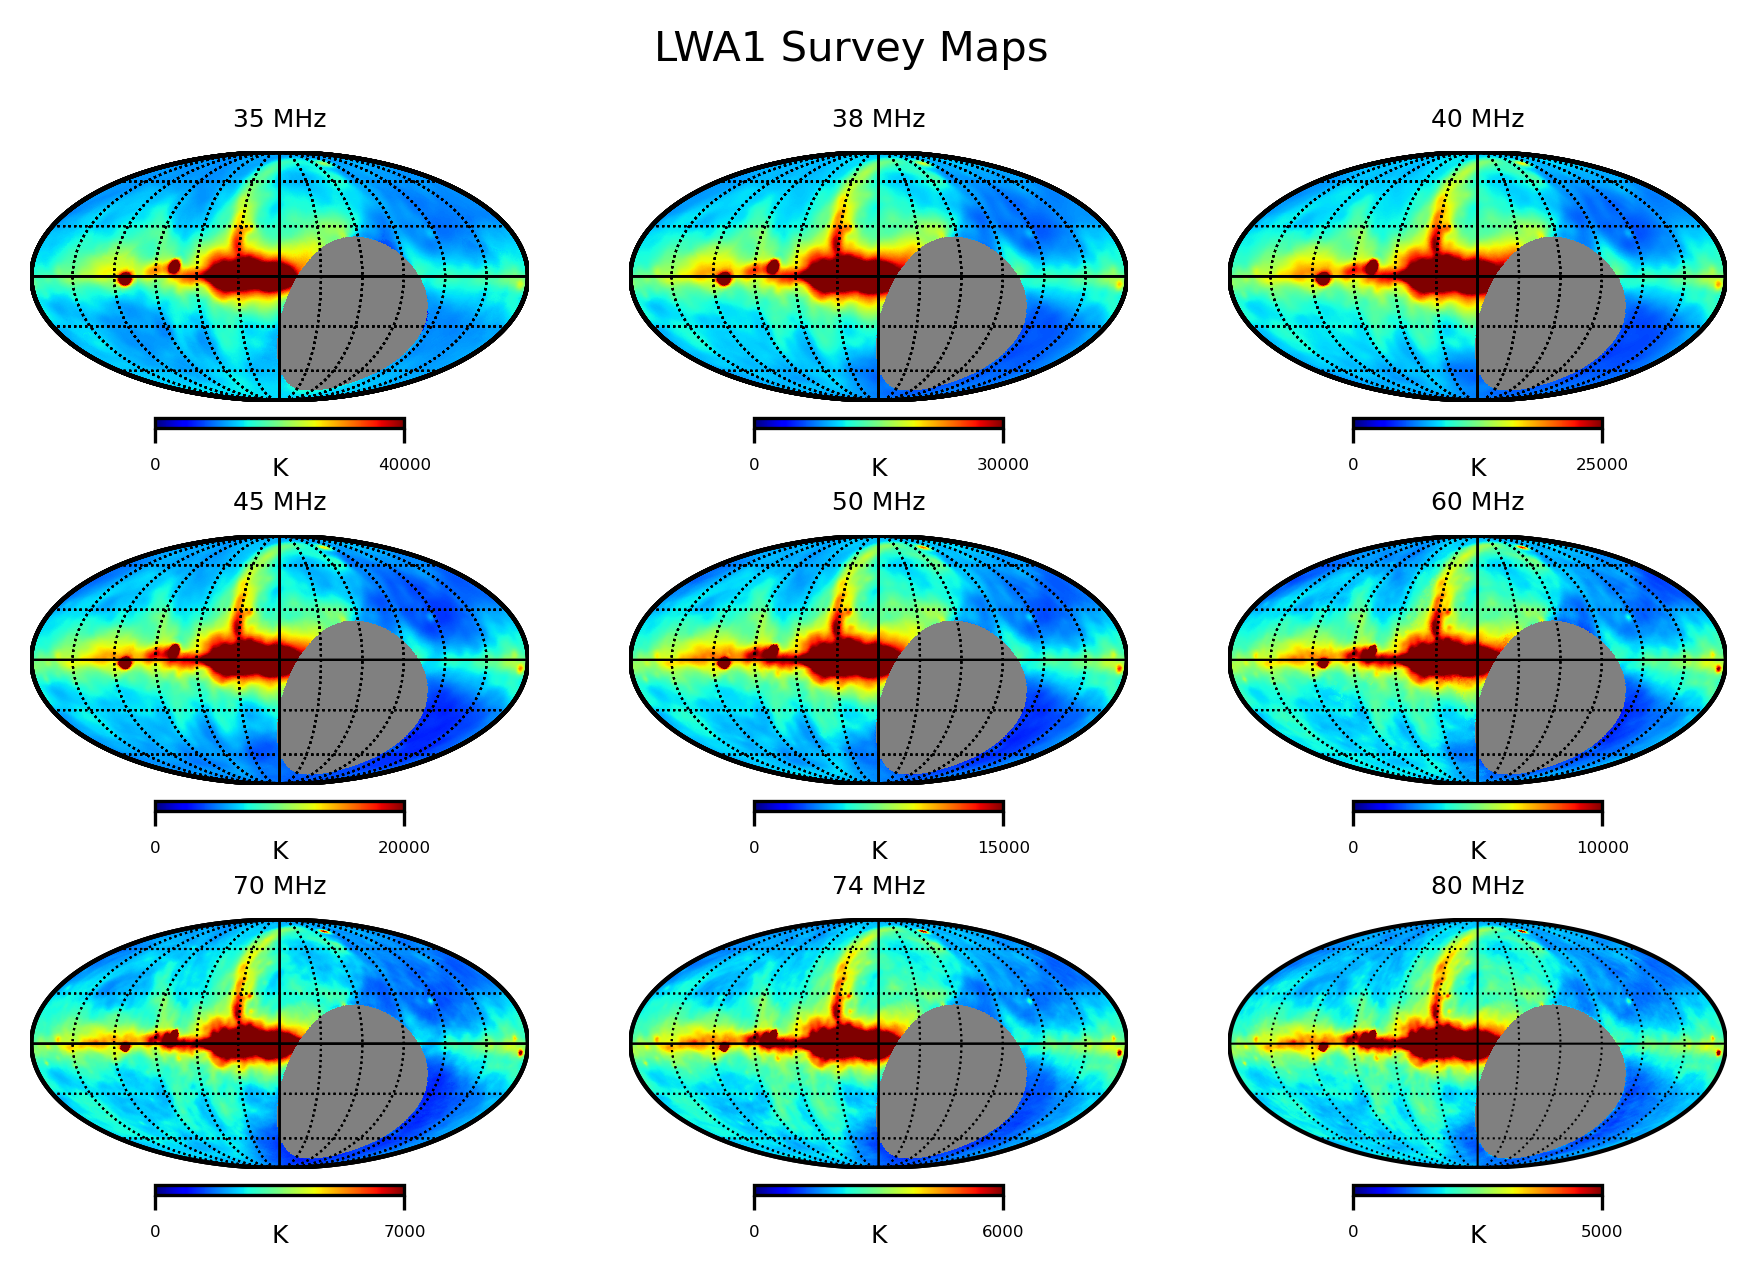

In [37]:
#
# Display the maps to check if they're okay
#
def plot_maps(maps, cbrange_K):
    """Plot the maps in a 3x3 grid.

    Args:
        maps (dict): Dictionary of maps to plot.
        cbrange_K (dict): Dictionary of colorbar ranges for each map.

    Returns:
        None: Displays the maps in a 3x3 grid.

    Notes:
        The maps are plotted in a 3x3 grid, with the colorbar range for each map
        set to the values in the cbrange_K dictionary.

    """
    fig, axs = plt.subplots(3, 3, figsize=(7.3, 4.8), dpi=300)
    mpl.rcParams['figure.titlesize'] = 10
    mpl.rcParams['axes.titlesize'] = 6
    mpl.rcParams['font.size'] = 4
    # mpl.rcParams['legend.title_fontsize'] = 8
    # mpl.rcParams['legend.fontsize'] = 8
    # mpl.rcParams['xtick.labelsize'] = 8
    # mpl.rcParams['ytick.labelsize'] = 8
    # mpl.rcParams['axes.labelsize'] = 8

    # plt.tight_layout()
    count = 0
    for ax,freq,map in zip(axs.flat, maps.keys(), maps.values()):
        # print(ax)
        plt.axes(ax)
        mrgn = 1.0
        margins = (mrgn,mrgn,mrgn,mrgn)
        hp.mollview(map, title=f"{freq} MHz", min=cbrange_K[freq][0], max=cbrange_K[freq][1], xsize=2000, cmap='jet', unit='K', hold=True)
        # hp.mollview(map, title=f"{freq} MHz", min=0.0, max=8000.0, xsize=2000, cmap='jet', unit='K', margins=margins, hold=True)
        hp.graticule(lw=0.5)

        # hp.mollview(celest_lwa180/1000, min=0.9, max=4.5, coord=['C', 'G'], cmap='gist_heat', unit='kK')
        # hp.mollview(map_lwa180/1000, min=0.9, max=4.5, coord=['C', 'G'], cmap='gist_heat')
        # hp.mollview(map_lwa180, coord=['C', 'G'])
        # hp.mollview(map_lwa180,  coord=['C', 'G'], norm="hist")

        ### Change font size of colorbar units text in hp.mollview ###
        f = plt.gcf().get_children() # accessing the current figure...
        # print(f)
        # print(len(f))
        # print(f[-1]) # ... then the colorbar's elements
        CbAx = f[-1].get_children() # ... then the colorbar's elements
        # print(CbAx)
        # print(len(CbAx))
        coord_text_obj = CbAx[2] # [1] corresponds to the particular label of the
                                            # colorbar, i.e. "Field value" in this case
        coord_text_obj.set_fontsize(6)
        coord_text_obj.set_y(-4.0)
        # plt.show()
        
        #
        # Save just the single frequency map (subplot)
        #
        # Pad the saved area by 10% in the x-direction and 10% in the y-direction
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

        LWA1_map_image_dir = Path(LWA1_map_images_path/f'LWA1-00{freq}/')
        LWA1_map_image_dir.mkdir(parents=True, exist_ok=True)
        LWA1_map_image_file = f"LWA1-00{freq}_map.png"
        fig.savefig(LWA1_map_image_dir/LWA1_map_image_file, bbox_inches=extent.expanded(1.01, 1.20), dpi=300)
        # fig.savefig(LWA1_map_images_path/f'LWA1-00{freq}/LWA1-00{freq}_map.png', bbox_inches=extent)

        count = count + 1

    fig.suptitle("LWA1 Survey Maps", y=0.95)
    plt.tight_layout()
    # fig.subplots_adjust(top=0.95)
    # fig.tight_layout()

    # 
    # Save the whole figure as a png image
    # 
    LWA1_allmaps_image_file = f"LWA1_allmaps.png"
    plt.savefig(LWA1_map_images_path/LWA1_allmaps_image_file, dpi=300, bbox_inches='tight')

plot_maps(maps_lwa1, cbrange_K)


<ipython-input-38-930176789bbf>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


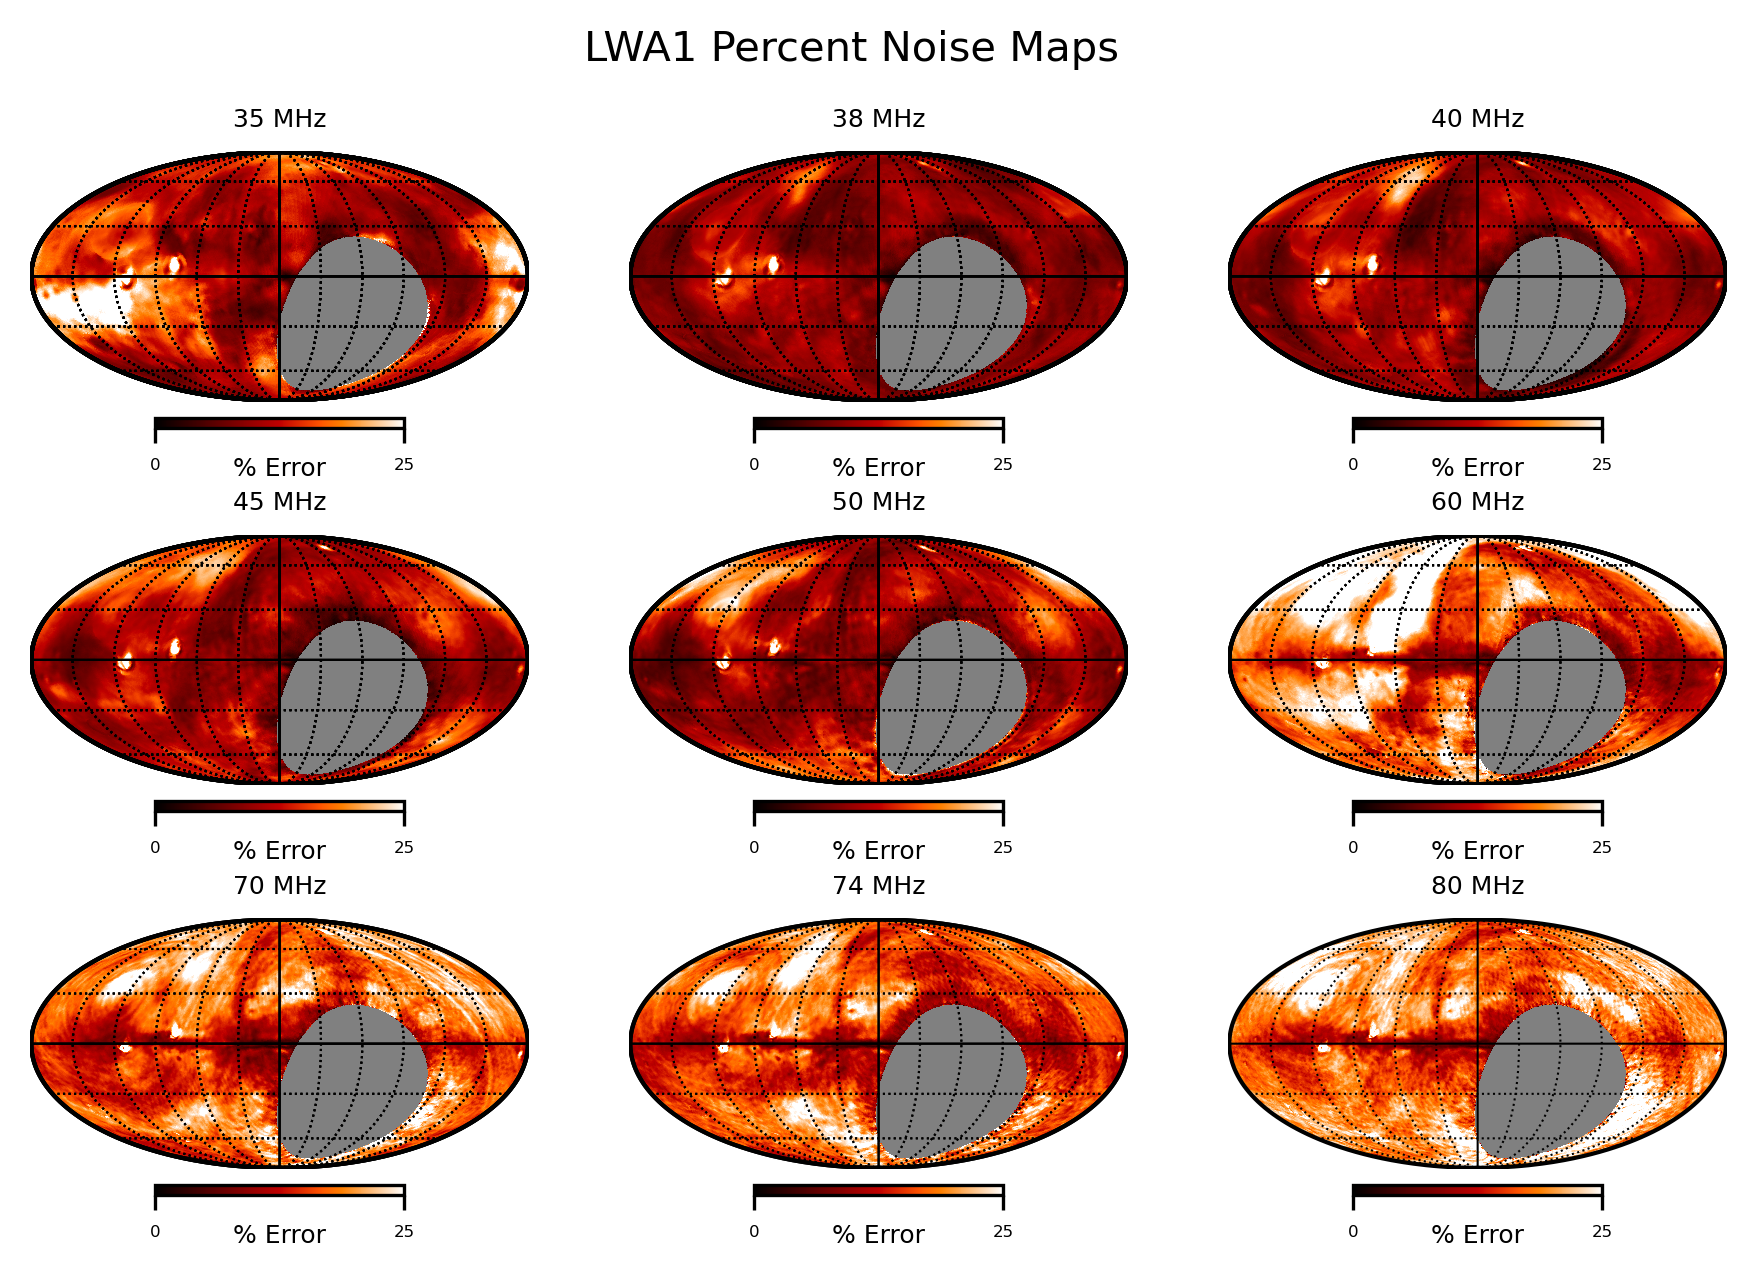

In [38]:
# Create a function to plot the percentage error/noise maps in a 3x3 grid the same way as above
def plot_noise_maps(pct_errs):
    """Plot the noise maps in a 3x3 grid.
    
    Args:
        pct_errs (dict): Dictionary of percent noise maps to plot.
        
    Returns:
        None: Displays the maps in a 3x3 grid.

    Notes:
        The maps are plotted in a 3x3 grid, with the colorbar range for each map
        set to the values in the cbrange_K dictionary.

    """
    fig, axs = plt.subplots(3, 3, figsize=(7.3, 4.8), dpi=300)
    mpl.rcParams['figure.titlesize'] = 10
    mpl.rcParams['axes.titlesize'] = 6
    mpl.rcParams['font.size'] = 4

    for ax,freq,pct_err in zip(axs.flat, pct_errs.keys(), pct_errs.values()):
        plt.axes(ax)
        hp.mollview(pct_err, title=f"{freq} MHz", min=0.0, max=25.0, xsize=2000, cmap='gist_heat', unit='% Error', hold=True)
        # Draw graticule lines using hp.graticule() with line-width of 0.5:
        hp.graticule(lw=0.5)

        

        ### Change font size of colorbar units text in hp.mollview ###
        f = plt.gcf().get_children() # accessing the current figure...
        CbAx = f[-1].get_children() # ... then the colorbar's elements
        coord_text_obj = CbAx[2] # [1] corresponds to the particular label of the
                                            # colorbar, i.e. "Field value" in this case
        coord_text_obj.set_fontsize(6)
        coord_text_obj.set_y(-4.0)

        # Save just the single frequency map (subplot)
        # Pad the saved area by 10% in the x-direction and 10% in the y-direction
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        LWA1_pcterr_image_dir = Path(LWA1_map_images_path/f'LWA1-00{freq}/')
        LWA1_pcterr_image_dir.mkdir(parents=True, exist_ok=True)
        LWA1_pcterr_image_file = f"LWA1-00{freq}_pcterr.png"
        fig.savefig(LWA1_pcterr_image_dir/LWA1_pcterr_image_file, bbox_inches=extent.expanded(1.01, 1.20), dpi=300)
    
    fig.suptitle("LWA1 Percent Noise Maps", y=0.95)
    plt.tight_layout()

    # 
    # Save the whole figure as a png image
    # 
    LWA1_allpcterrs_image_file = f"LWA1_allpcterrs.png"
    plt.savefig(LWA1_map_images_path/LWA1_allpcterrs_image_file, dpi=300, bbox_inches='tight')

plot_noise_maps(pct_errs_lwa1)
    